In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Import libraries and modules
I used nd2reader to read .nd2. It should be ok to output confocal images to .tiff or other common digital image format. Additionally, I used matplotlib.pyplot to draw figures. Numpy was used to process data.

In [2]:
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import numpy as np

# Open .nd2 and convert timesteps to real time
Basically, this file (.ipynb) and the target confocal file must be in the same folder. Then put the file name in the ().

/Users/IanLi/miniconda3/envs/minimal/lib/python3.9/site-packages/nd2reader/common_raw_metadata.py:99: RuntimeWarning: Reported average frame interval (32770.6 ms) doesn't match the set interval (30000.0 ms). Using the average now.
  warnings.warn(message % (avg_interval, interval), RuntimeWarning)


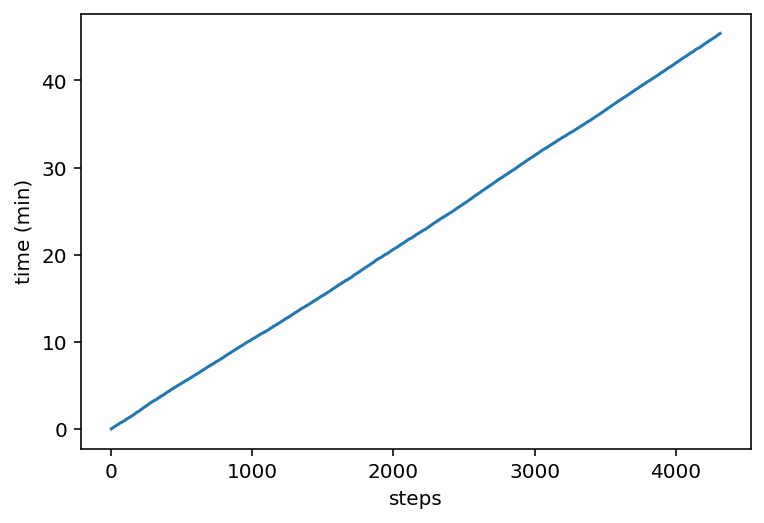

In [3]:
with ND2Reader('sample_1_movie_positive.nd2') as img:
    timesteps = img.get_timesteps() / 1000 / 60   # in minutes
    plt.plot(timesteps)
    plt.xlabel('steps')
    plt.ylabel('time (min)')

# Basic codes for nd2reader
Nd2reader has a page on GitHub. You can find a documentation or more information there.
https://github.com/rbnvrw/nd2reader

In [4]:
with ND2Reader('sample_1_movie_positive.nd2') as img:
    pass 
    # add # infront of pass if you want to try the basic codes listed below.
    # print(img.sizes) # check the size of img. The parameters are x, y, c, t ,z
    # print(img.metadata) # list the metadata of the img. 

/Users/IanLi/miniconda3/envs/minimal/lib/python3.9/site-packages/nd2reader/common_raw_metadata.py:99: RuntimeWarning: Reported average frame interval (32770.6 ms) doesn't match the set interval (30000.0 ms). Using the average now.
  warnings.warn(message % (avg_interval, interval), RuntimeWarning)


# Penetration profile with nanoemulsions' signal
I create a array to store average intensities of every xy planes. I store the value with regard to z-axis and t-axis.

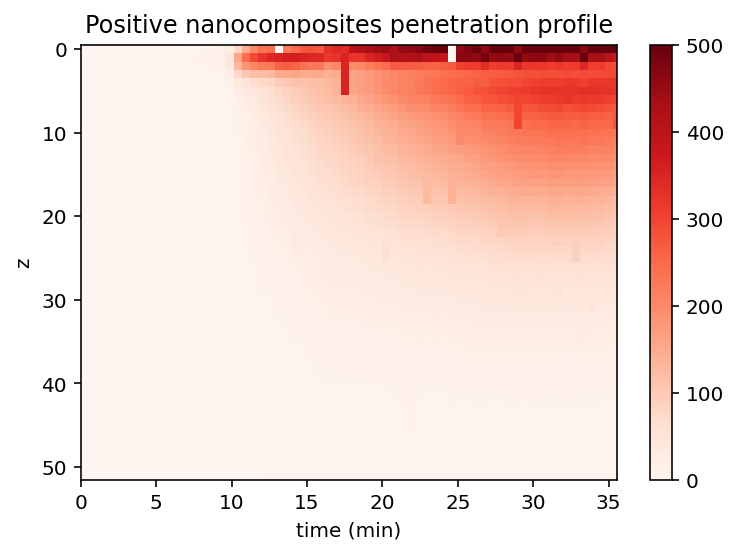

In [5]:
with ND2Reader('sample_1_movie_positive.nd2') as img:
    
    # identify z- and t- ranges for iteration
    nz = len(img.metadata['z_levels']) # z-level range
    nt = len(img.metadata['frames']) # time range
    
    # create an array to store average intensities of the XY planes with regard to z and t.
    array = np.zeros((nz, nt))
    # create an array to store average intensities of the XY planes with regard to t == 0, 
    # indicating the background intensities.
    array_bg = np.zeros((nz, 1)) # only store intensity when t == 0
    
    # First, I want to get the backgroud intensities of the XY-planes.
    # as the img has multiple dimentions, we iterate XY planes with regard to z first. 
    # Also, at this iteration, I set t = 0 to get the background intensities.
    img.bundle_axes = 'yx'
    img.iter_axes = 'z'
    img.default_coords['t'] = 0 # t = 0 for background
    
    # loop z-axis, store the mean intensities of the XY-planes in array_bg[z, 0].
    for z in range(nz):
        array_bg[z, 0] = img[z].mean()
    
    # Now we are going to generate the penetration profile. I iterate t-axis. 
    # Additionally, for each t, I iterate XY-planes with regard to z-axis.
    # Don't for get to substract the background intensity.
    # Finally, I store the mean values of the XY-planes in the array.
    
    for t in range(nt):
        img.default_coords['t'] = t
        for z in range(nz):
            img_value = img[z] - array_bg[z, 0]
            array[z, t] = img_value.mean()
    
    # Generate figures using matplotlib.pyplot
    plt.imshow(array, plt.cm.Reds, aspect='auto')
    plt.clim(0, 500) #set a colorbar range
    plt.colorbar()
    plt.xlabel('time (min)')
    plt.ylabel('z')
    plt.title('Positive nanocomposites penetration profile')
    t_ticks = np.arange(0, timesteps[-1], 5, dtype=int)
    plt.xticks(t_ticks / (timesteps[-1] / nt), t_ticks)
    plt.xlim([0,65])
    plt.show()

# Bacteria distribution
We located the biofilm using green channel (GFP-expressed bacteria), then scan the biofilm with regard to z-axis.
Please note the confocal settings especially z range must be the same as the penetration experiment.

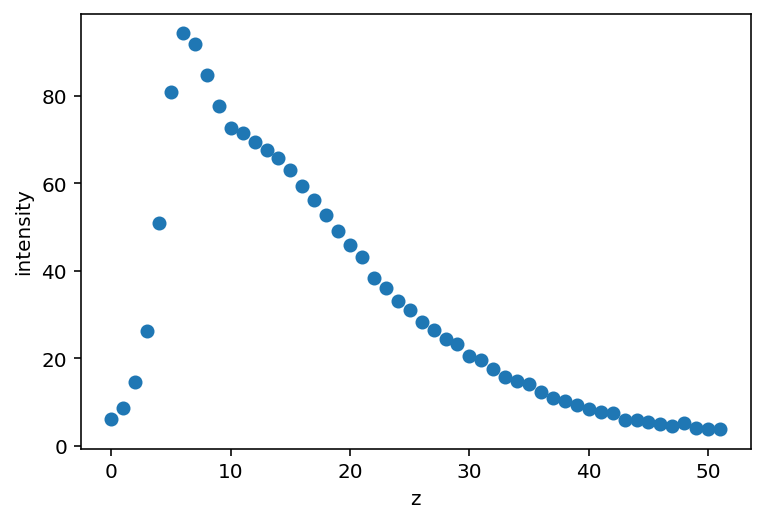

In [6]:
with ND2Reader('pkp_only_sample_1.nd2') as img:

    # This is a simple z-stacking (xyz), so just create an array to store the intensity.
    nz = len(img.metadata['z_levels'])
    array_GFP = np.zeros((nz, 1))
    
    # iterate xy-plans with regard to z-axis, then store the average in the array created above.
    for i in range(nz):
        array_GFP[i, 0] = img[i].mean()
    
    # Generate figures using matplotlib.pyplot
    plt.scatter(range(nz), array_GFP)
    plt.xlabel('z')
    plt.ylabel('intensity')

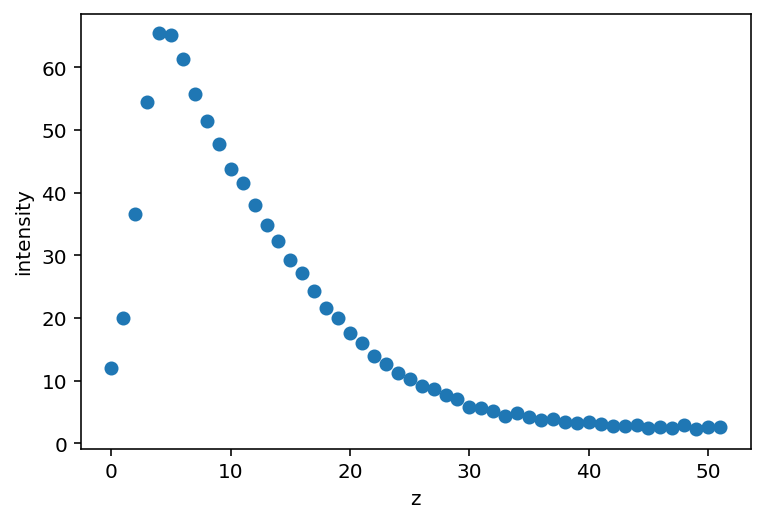

In [7]:
with ND2Reader('sample_1_positive_after_45_min.nd2') as img:
    
    # same thing as cell 5. The intensity before the experiment looked weired, 
    # so I check the intensity after the treatment.
    
    nz = len(img.metadata['z_levels'])
    array_GFP = np.zeros((nz, 1))
    
    for i in range(nz):
        array_GFP[i, 0] = img[i].mean()
    
    # Generate figures using matplotlib.pyplot
    plt.scatter(range(nz), array_GFP)
    plt.xlabel('z')
    plt.ylabel('intensity')

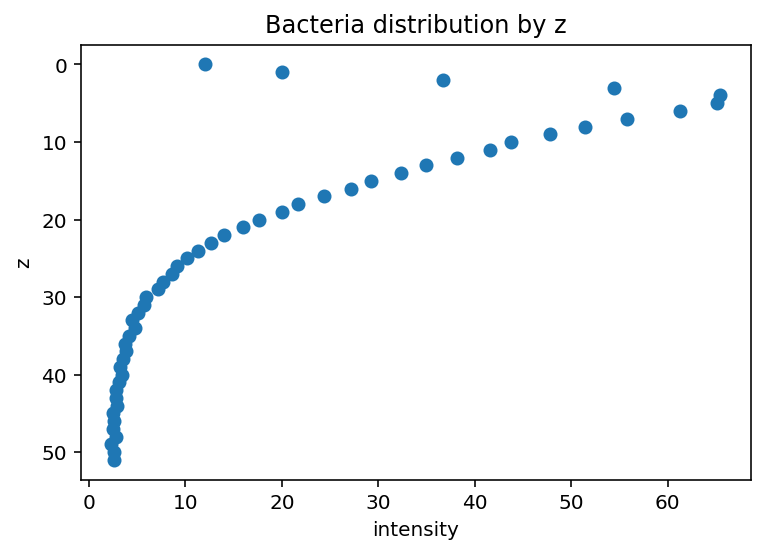

In [8]:
with ND2Reader('sample_1_positive_after_45_min.nd2') as img:
    
    # just rotate the figure axis...
    nz = len(img.metadata['z_levels'])
    array_GFP = np.zeros((nz, 1))
    
    for i in range(nz):
        array_GFP[i, 0] = img[i].mean()
    
    # Generate figures using matplotlib.pyplot
    plt.scatter(array_GFP, range(nz))
    plt.gca().invert_yaxis()
    plt.ylabel('z')
    plt.xlabel('intensity')
    plt.title('Bacteria distribution by z')

# Convert z-level to bacteria percentage
Every biofilm is different. We normalize the biofilm so we can compare them.

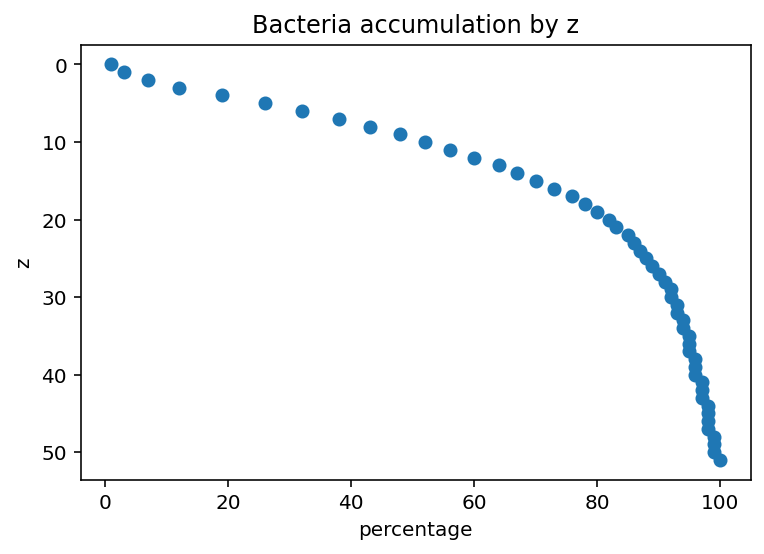

In [9]:
with ND2Reader('sample_1_positive_after_45_min.nd2') as img:
    
    # just create a numpy array or a list to store the accumulation of the intensities to caculate percentage.
    nz = len(img.metadata['z_levels'])
    array_GFP = [0] * nz
    
    # Iterate the xy-planes and store the mean intensity value to the list created above.
    for i in range(nz):
        array_GFP[i] = img[i].mean()
    
    # Now we have mean intensities of xy planes in the list.
    # To calculate the accumalation oh the intensity from the top, we have a new list and the first value is the
    # the average intensity of the top xy-plane. The second value is the average intensity of the top xy-plane
    # and second top xy-plane, and so on... To get the percentage, each value needs to be divided by the summary
    # of the values.
    
    array_GFP_accumulate = [int(sum(array_GFP[0: i + 1]) / sum(array_GFP) * 100) for i in range(nz)]
    
    # Generate figures using matplotlib.pyplot
    plt.scatter(array_GFP_accumulate, range(nz))
    plt.gca().invert_yaxis()
    plt.ylabel('z')
    plt.xlabel('percentage')
    plt.title('Bacteria accumulation by z')

# Penetration profile (bacteria percentage v.s. time)
This penetration is the same as the cell 4. We just convert the axis from z-level to bacteria percentage.

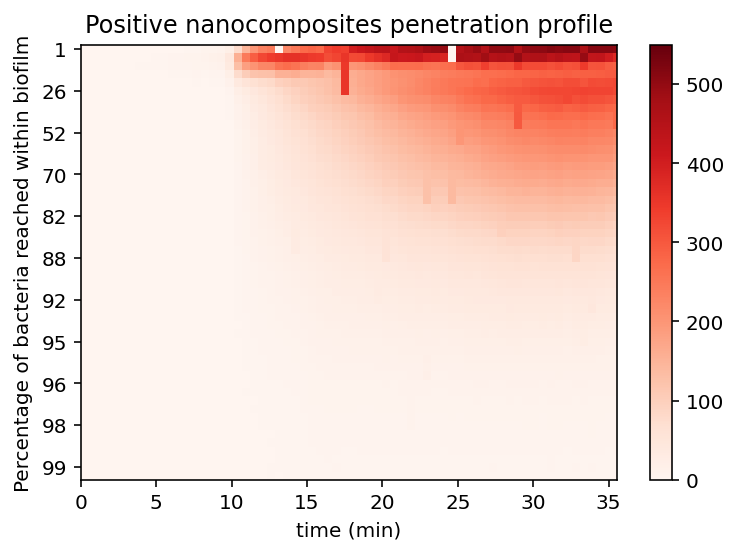

In [10]:
with ND2Reader('sample_1_movie_positive.nd2') as img:

    nz = len(img.metadata['z_levels']) # z-level range
    nt = len(img.metadata['frames']) # time range    
    array = np.zeros((nz, nt))
    array_bg = np.zeros((nz, 1)) # only store intensity when t = 0
  
    img.bundle_axes = 'yx'
    img.iter_axes = 'z'
    
    img.default_coords['t'] = 0 # t = 0 for background
    
    for z in range(nz):
        array_bg[z, 0] = img[z].mean()
        
    for t in range(nt):
        img.default_coords['t'] = t
        for z in range(nz):
            img_value = img[z] - array_bg[z, 0]
            array[z, t] = img_value.mean()
    
    plt.imshow(array, plt.cm.Reds, aspect='auto')
    plt.clim(0, 550)
    plt.colorbar()
    plt.xlabel('time (min)')
    plt.ylabel('Percentage of bacteria reached within biofilm')
    plt.title('Positive nanocomposites penetration profile')
    t_ticks = np.arange(0, timesteps[-1], 5, dtype=int)
    plt.xticks(t_ticks / (timesteps[-1] / nt), t_ticks)
    y_ticks = np.arange(0, nz, 5, dtype=int)
    ###
    # below is the code different from the cell 4
    # label the axis with the accumulation information we got in the cell 8
    plt.yticks(y_ticks, array_GFP_accumulate[::5])
    ###
    plt.xlim([0,65])
    plt.show()

# Remove small particle (nanoemulsion)
I used scikit-image library to remove signal of the nanoemulsion. The particle size difference between the bacteria (> 1 µm) and the nanoemulsion (~250 nm) was used to remove the nanoemulsion signals. I first use threshold to locate coordinates of the bacteria and the nanoemulsions. This step label the bacteria and nanoemulsion as 1 and others (should be noisy) as 0. If I did not do this step, skimage.morphology module cannot remove nanoemulsion because every are bind together.

In [12]:
import skimage
from skimage.filters import threshold_mean
import skimage.morphology

/Users/IanLi/miniconda3/envs/minimal/lib/python3.9/site-packages/nd2reader/common_raw_metadata.py:99: RuntimeWarning: Reported average frame interval (32770.6 ms) doesn't match the set interval (30000.0 ms). Using the average now.
  warnings.warn(message % (avg_interval, interval), RuntimeWarning)


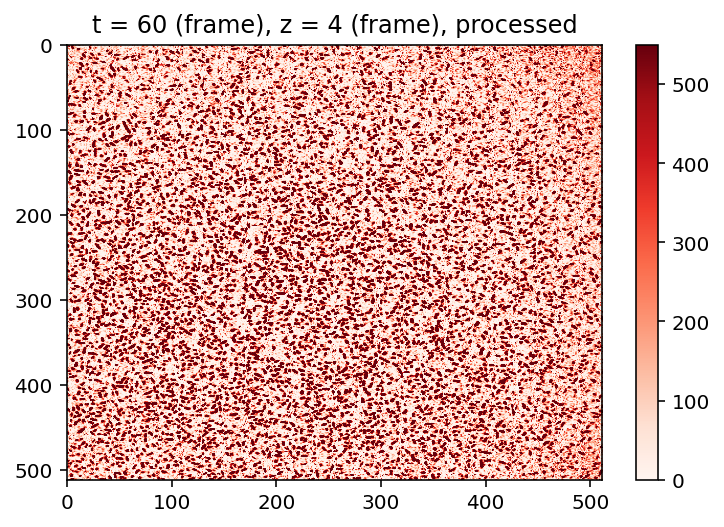

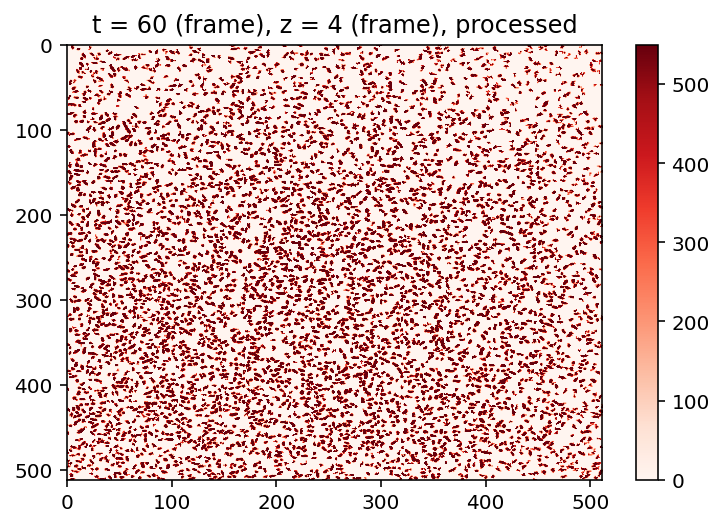

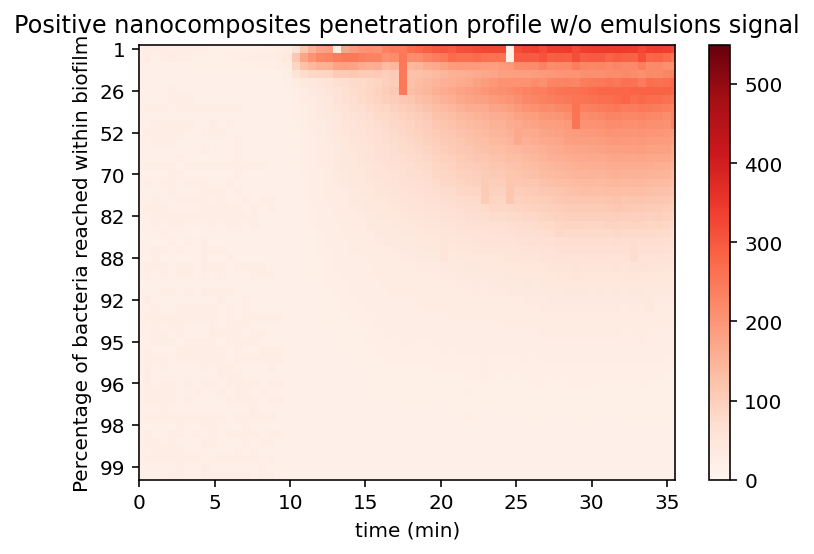

In [13]:
with ND2Reader('sample_1_movie_positive.nd2') as img:
    
    nz = len(img.metadata['z_levels']) # z-level range
    nt = len(img.metadata['frames']) # time range
    
    array = np.zeros((nz, nt))
    array_bg = np.zeros((nz, 1)) # only store intensity when t = 0
  
    img.bundle_axes = 'yx'
    img.iter_axes = 'z'
    
    img.default_coords['t'] = 0 # t = 0 for background
    
    for z in range(nz):
        array_bg[z, 0] = img[z].mean()
        
    for t in range(nt):
        img.default_coords['t'] = t
        for z in range(nz):
            img_value = img[z] - array_bg[z, 0]
            thresh = threshold_mean(img_value) #
            mask = img[z] > thresh
            mask = skimage.morphology.remove_small_objects(mask, 6, connectivity=1)
            processed = img[z] * mask
            array[z, t] = processed.mean()
            
            # The code below just for checkcing... if you just need to generate the profile, """ """ them.
            if t == 60 and z == 4: #check the confocal imges
                plt.imshow(img_value, plt.cm.Reds, aspect='auto')
                plt.colorbar()
                plt.title('t = 60 (frame), z = 4 (frame), processed')
                plt.clim(0, 550) 
                plt.show()
                
                plt.imshow(processed, plt.cm.Reds, aspect='auto')
                plt.colorbar()
                plt.title('t = 60 (frame), z = 4 (frame), processed')
                plt.clim(0, 550) 
                plt.show()
    
    plt.imshow(array, plt.cm.Reds, aspect='auto')
    plt.clim(0, 550) #set a colorbar range
    plt.colorbar()
    plt.xlabel('time (min)')
    plt.ylabel('Percentage of bacteria reached within biofilm')
    plt.title('Positive nanocomposites penetration profile w/o emulsions signal')
    t_ticks = np.arange(0, timesteps[-1], 5, dtype=int)
    plt.xticks(t_ticks / (timesteps[-1] / nt), t_ticks)
    y_ticks = np.arange(0, nz, 5, dtype=int)
    plt.yticks(y_ticks, array_GFP_accumulate[::5])
    plt.xlim([0,65])
    plt.show()

# Why need to use threshold?

# 

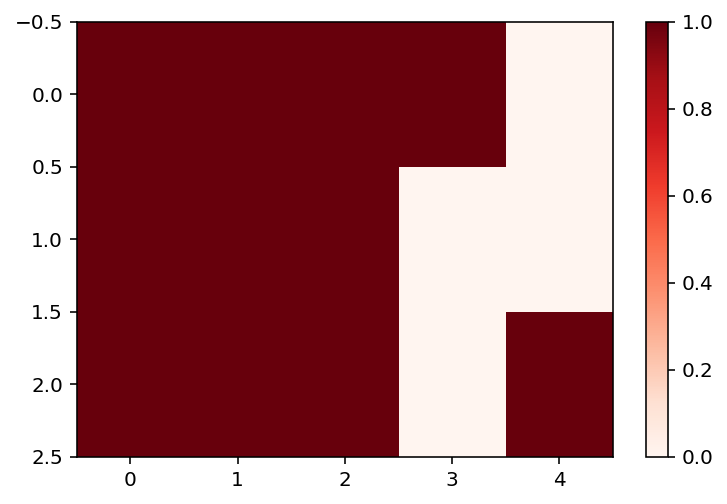

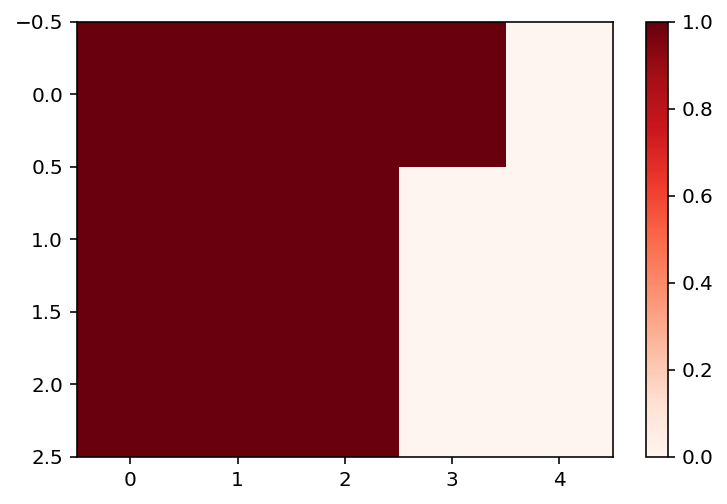

In [19]:
#pixels with 0 are consider as sea. (Sea-Island proble)
a = np.array([[1, 1, 1, 1, 0],
               [2, 2, 2, 0, 0],
               [2, 2, 2, 0, 1]], bool)

plt.imshow(a, plt.cm.Reds, aspect='auto')
plt.colorbar()
plt.show()

filter_img = skimage.morphology.remove_small_objects(a, 6, connectivity=1)

plt.imshow(filter_img, plt.cm.Reds, aspect='auto')
plt.colorbar()
plt.show()

[[0. 1. 2. 0.]
 [3. 4. 5. 0.]
 [6. 7. 8. 0.]
 [0. 0. 0. 0.]]
AxesSubplot(0.125,0.125;0.775x0.755)


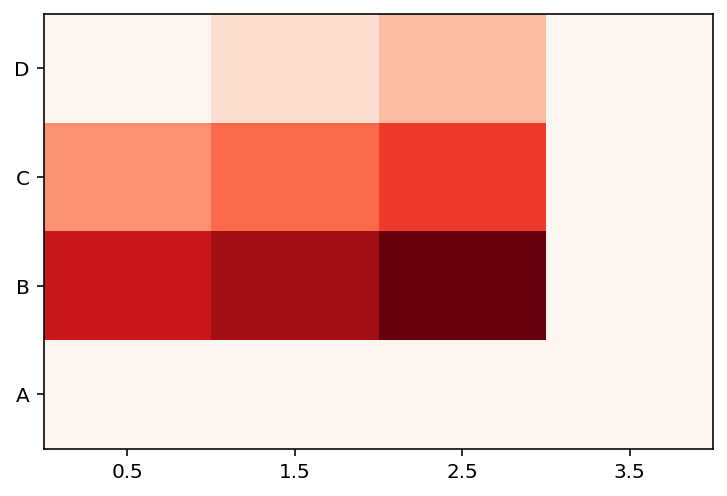

In [17]:
data = np.zeros((4, 4))

for i in range(9):
    data[i // 3][i % 3] = i
print(data)

plt.imshow(data, plt.cm.Reds, extent=[0,4,0,4], aspect='auto')
ax = plt.gca()
print(ax)
xticks = [0.5,1.5,2.5,3.5]
yticks = [0.5,1.5,2.5,3.5]
xticks_label = [0.5,1.5,2.5,3.5]
yticks_label = ['A','B','C','D']
ax.set_xticks(xticks)
ax.set_yticks(xticks)
ax.set_yticklabels(yticks_label)
plt.show()